## Step 1: Environment setup, Library Imports, and Data Load

In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
import kagglehub
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

from openai import OpenAI
my_key = os.getenv('CHAT_GPT_KEY')
apikey = my_key

/Users/vijaypatha/Developer/ML_LLM/Regression/BankChurners/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("sakshigoyal7/credit-card-customers")
df = pd.read_csv(path + "/BankChurners.csv") 
df.head(3)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998


## Step 2: Exploratory Data Analysis (EDA) 
 Prepare a refined dataset for further analysis, such as applying machine learning models or large language models

### 2.1 Data Understanding
Examine data types, basic statistics, and overall structure

In [3]:
print(f"DataFrame Shape: {df.shape}")
print("\nData types of columns:")
display(df.dtypes)
print("\nDataFrame Info:")
df.info()

DataFrame Shape: (10127, 23)

Data types of columns:


CLIENTNUM                                                                                                                               int64
Attrition_Flag                                                                                                                         object
Customer_Age                                                                                                                            int64
Gender                                                                                                                                 object
Dependent_count                                                                                                                         int64
Education_Level                                                                                                                        object
Marital_Status                                                                                                                         object
Income


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                          

In [4]:
df = df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'])
df = df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
df = df.drop(columns=['CLIENTNUM'])

In [5]:
print(f"Custom Statistics:\n{df.select_dtypes(include='number').agg(['mean', 'std', 'nunique'])}")

Custom Statistics:
         Customer_Age  Dependent_count  Months_on_book  \
mean        46.325960         2.346203       35.928409   
std          8.016814         1.298908        7.986416   
nunique     45.000000         6.000000       44.000000   

         Total_Relationship_Count  Months_Inactive_12_mon  \
mean                     3.812580                2.341167   
std                      1.554408                1.010622   
nunique                  6.000000                7.000000   

         Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
mean                  2.455317   8631.953698          1162.814061   
std                   1.106225   9088.776650           814.987335   
nunique               7.000000   6205.000000          1974.000000   

         Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  \
mean         7469.139637              0.759941      4404.086304   
std          9090.685324              0.219207      3397.129254   
nunique      6813.000000 

### 2.2 Distrubutions Visualizatons 

In [6]:
numerical_columns_in_df = df.select_dtypes(include=['number']).columns
print(f"Name of Numerical Columns in the Datafame are: {numerical_columns_in_df}")

Name of Numerical Columns in the Datafame are: Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')


In [7]:
selected_numerical_features = ['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',]

/var/folders/tn/bllk4s_n0k9g75m59d6nyp8w0000gn/T/ipykernel_49554/1178455896.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True, label=feature)
/var/folders/tn/bllk4s_n0k9g75m59d6nyp8w0000gn/T/ipykernel_49554/1178455896.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True, label=feature)
/var/folders/tn/bllk4s_n0k9g75m59d6nyp8w0000gn/T/ipykernel_49554/1178455896.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[feature], shade=True, label=feature)
/var/folders/tn/bllk4s_n0k9g75m59d6nyp8w0000gn/T/ipykernel_49554/1178455896.py:13: FutureWarning: 

`shade` is now deprec

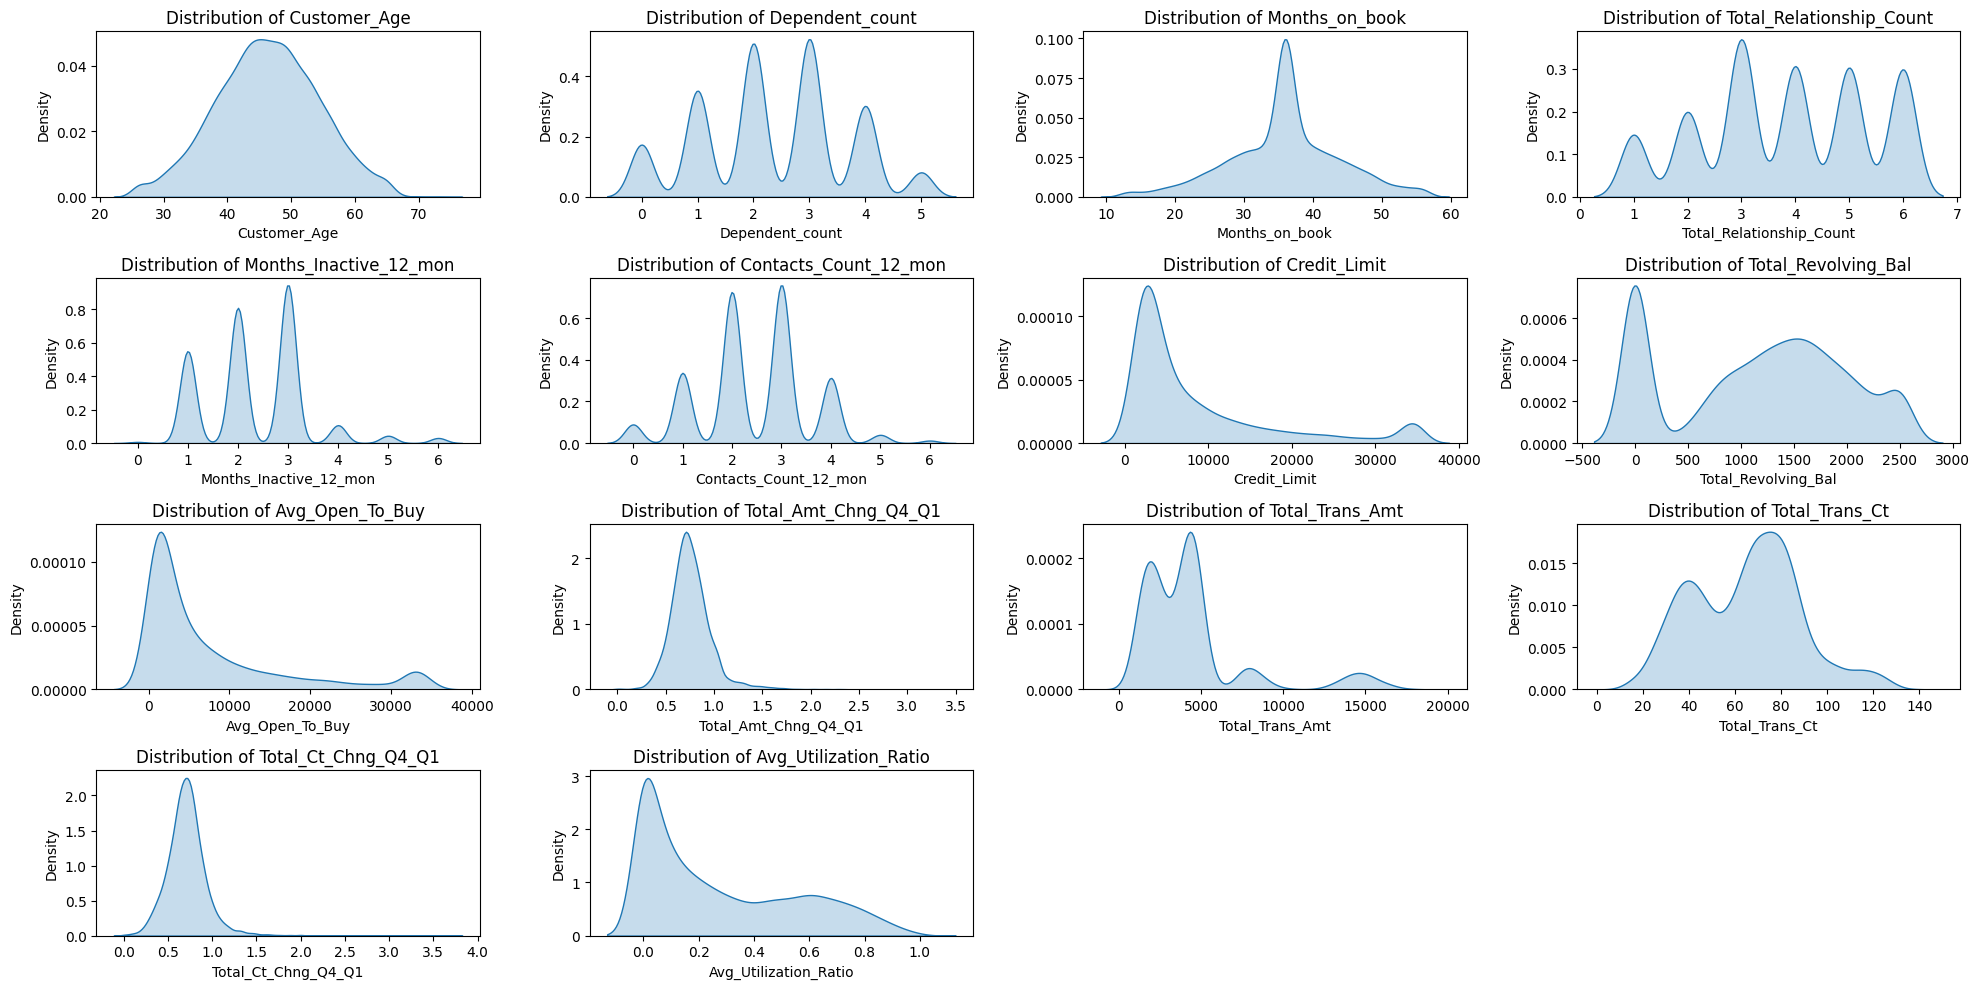

In [8]:
# I need a house(plt.figure) to hold the rooms (individual plots with size (12,10))

plt.figure(figsize=(20, 10)) 

for i in range(len(selected_numerical_features)):
    
    feature = selected_numerical_features[i]

    plt.subplot(4,4,i+1)
    #plt.subplot(nrows, ncols, index)
    # index here is the position where each subplot will appear in the grid.
    
    sns.kdeplot(df[feature], shade=True, label=feature)
    # sns.kdeplot(data, shade=False, label=None, **kwargs)
    
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel('Density')

    # Adjust layout for better spacing
plt.tight_layout()


### Step 2 Takeaways:
1. 23 columns (lables), Naive Bayes columns are not useful for my purpose
2. 6 are categorical features: Customer_Age, Gender, Education_Level, Marital_Status, Card_Category , Income_Category                                                   
3. ~11 K rows
4. CLIENTNUM could be an Index
5. Good mix of low (Customer_age), med (Total Rvolving Balance), high variable (credit limit) data points

### Step 3: Missing Data and Outliers

In [9]:
# Calculate percentage of missing values
missing_percentage = df.isnull().sum() / len(df) * 100
print(missing_percentage)

Attrition_Flag              0.0
Customer_Age                0.0
Gender                      0.0
Dependent_count             0.0
Education_Level             0.0
Marital_Status              0.0
Income_Category             0.0
Card_Category               0.0
Months_on_book              0.0
Total_Relationship_Count    0.0
Months_Inactive_12_mon      0.0
Contacts_Count_12_mon       0.0
Credit_Limit                0.0
Total_Revolving_Bal         0.0
Avg_Open_To_Buy             0.0
Total_Amt_Chng_Q4_Q1        0.0
Total_Trans_Amt             0.0
Total_Trans_Ct              0.0
Total_Ct_Chng_Q4_Q1         0.0
Avg_Utilization_Ratio       0.0
dtype: float64


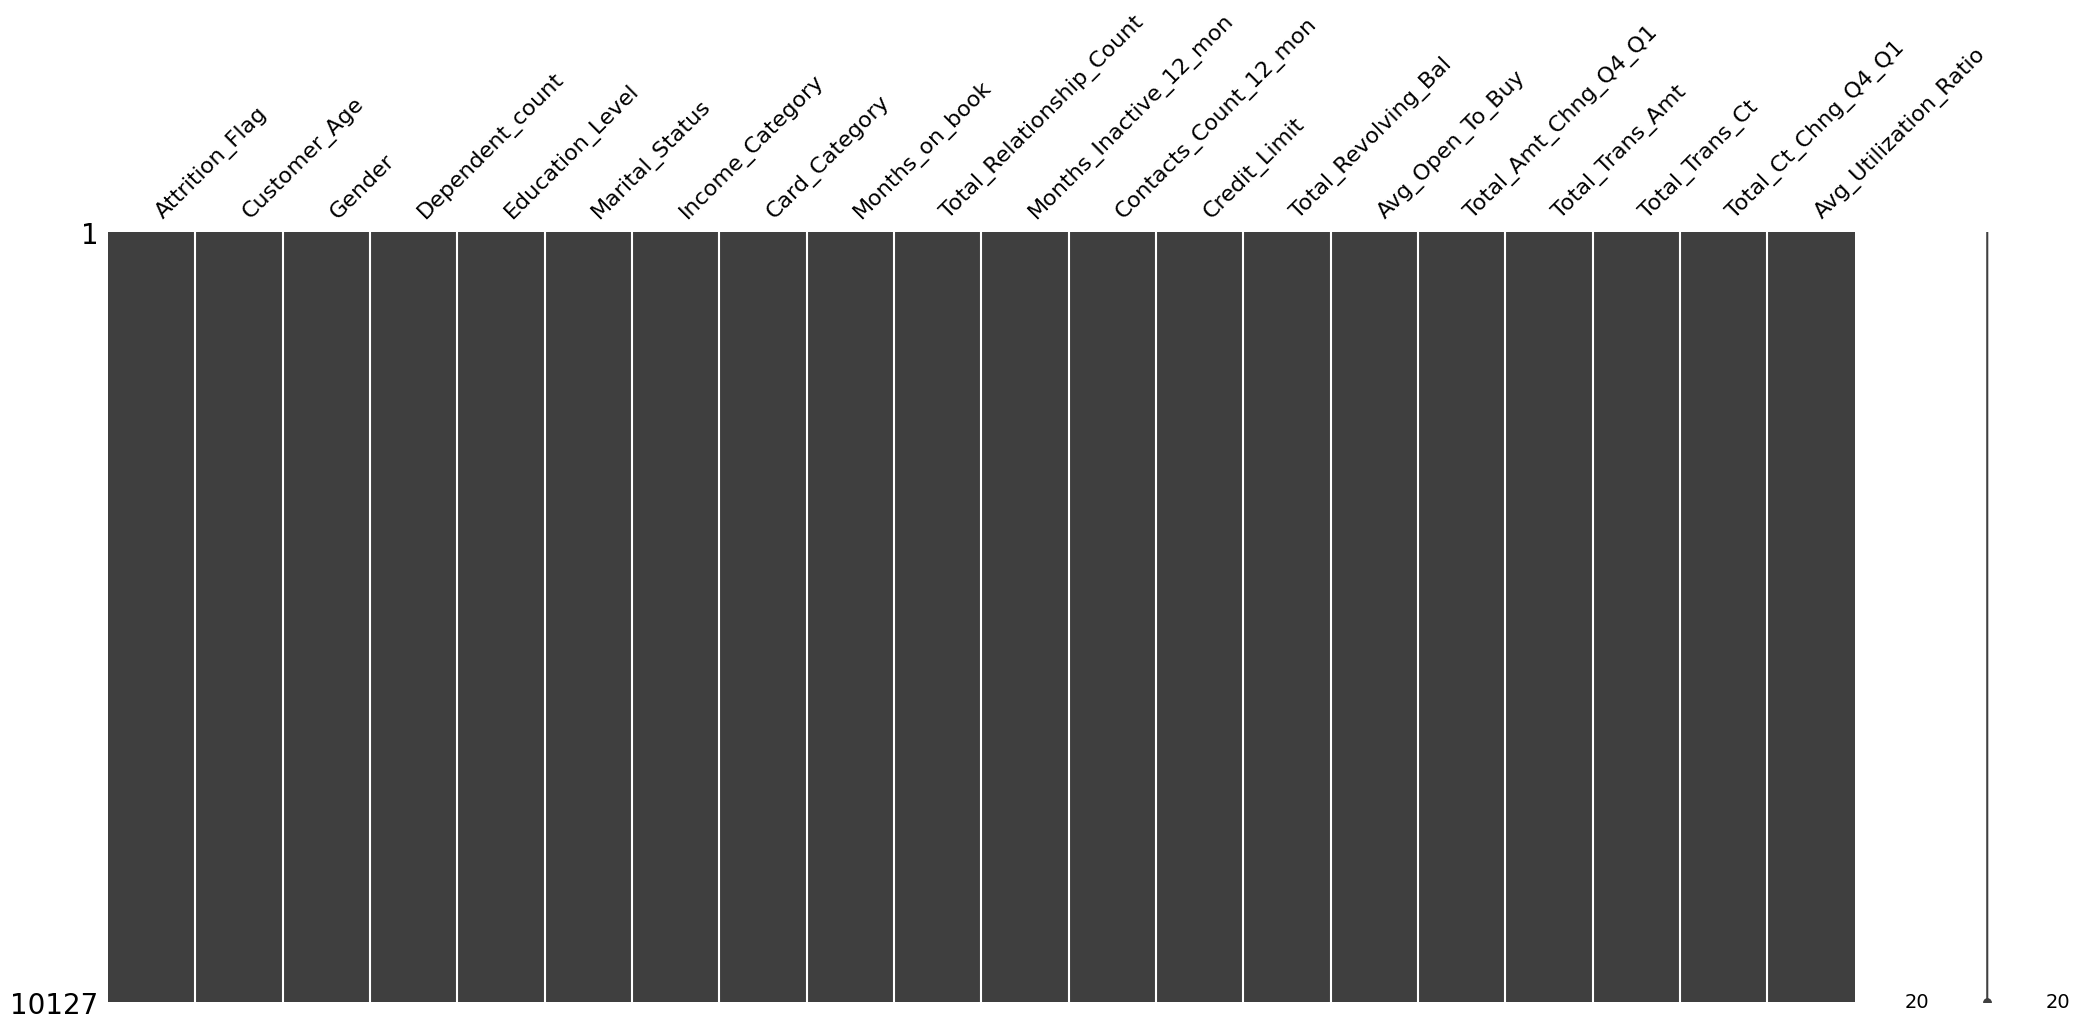

In [10]:
# Visualize missingness patterns
msno.matrix(df)  # Shows a matrix of missing values
plt.show()

### Step 4: Handling Skewed Distributions
we need to identify which features are skewed

In [11]:
# 1. Calculate Skewness
# Select only numerical columns (excluding object/categorical)
# |Skewness| < 0.5: Roughly symmetrical. Transformations are usually not necessary.
# 0.5 <= |Skewness| < 1: Moderately skewed. Consider a transformation (e.g., square root for moderate right skew, cube root for moderate left skew).
# |Skewness| >= 1: Highly skewed. Strongly consider a transformation (e.g., log transformation for high right skew, exponential transformation for high left skew).

numerical_cols = df.select_dtypes(include=np.number).columns
skewness = df[numerical_cols].skew()
print(skewness)

Customer_Age               -0.033605
Dependent_count            -0.020826
Months_on_book             -0.106565
Total_Relationship_Count   -0.162452
Months_Inactive_12_mon      0.633061
Contacts_Count_12_mon       0.011006
Credit_Limit                1.666726
Total_Revolving_Bal        -0.148837
Avg_Open_To_Buy             1.661697
Total_Amt_Chng_Q4_Q1        1.732063
Total_Trans_Amt             2.041003
Total_Trans_Ct              0.153673
Total_Ct_Chng_Q4_Q1         2.064031
Avg_Utilization_Ratio       0.718008
dtype: float64


Obvoiosuly, there are really highly skewed features. But are they worth transforming?

In [12]:
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### Step 5: The "Importance Before Transformation" Approach

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  # If Attrition_Flag is string

In [ ]:
# Handle potential errors from pd.get_dummies, adding errors='ignore'
X = df.drop(columns=['Attrition_Flag'], errors='ignore')
y = df['Attrition_Flag'] # Target variable

# Convert y to numerical if it's string 
if y.dtype == 'object':
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

In [16]:
# --- 2. NOW Handle Categorical Features (One-Hot Encode X) ---
X = pd.get_dummies(X, drop_first=True)

In [17]:
# Split data (optional, but good practice for a more robust estimate)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# --- 3. Train a Quick Model (Random Forest) ---

model = RandomForestClassifier(random_state=42, n_estimators=100)  # Use a reasonable n_estimators
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
# --- 4. Extract Feature Importances ---

importances = model.feature_importances_
feature_names = X_train.columns  # Use X_train.columns after one-hot encoding


In [20]:
# Create a DataFrame for easier handling
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

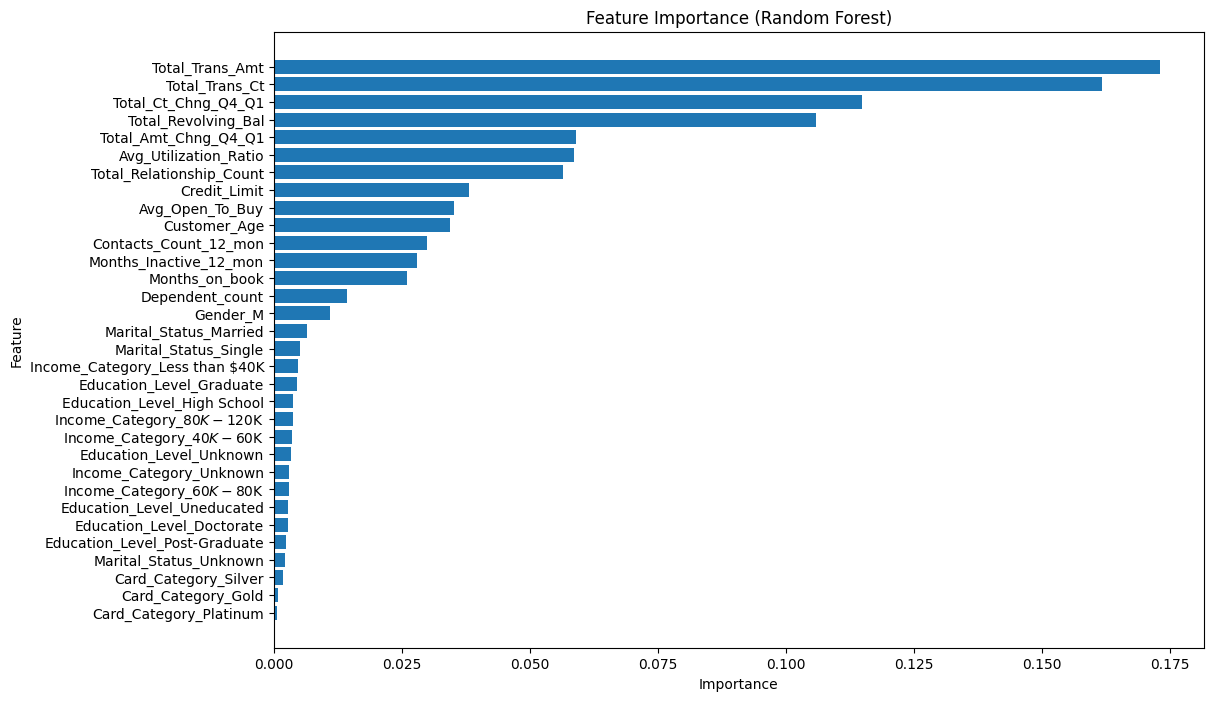

In [21]:
# --- 5. Visualize Feature Importances ---

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  # Show most important at the top
plt.show()

In [22]:
# --- 6. Prioritize Transformations ---
print(importance_df)

                           Feature  Importance
10                 Total_Trans_Amt    0.172949
11                  Total_Trans_Ct    0.161714
12             Total_Ct_Chng_Q4_Q1    0.114892
7              Total_Revolving_Bal    0.105766
9             Total_Amt_Chng_Q4_Q1    0.059028
13           Avg_Utilization_Ratio    0.058579
3         Total_Relationship_Count    0.056357
6                     Credit_Limit    0.038113
8                  Avg_Open_To_Buy    0.035137
0                     Customer_Age    0.034386
5            Contacts_Count_12_mon    0.029868
4           Months_Inactive_12_mon    0.027902
2                   Months_on_book    0.026029
1                  Dependent_count    0.014369
14                        Gender_M    0.010886
21          Marital_Status_Married    0.006387
22           Marital_Status_Single    0.005048
27  Income_Category_Less than $40K    0.004723
16        Education_Level_Graduate    0.004592
17     Education_Level_High School    0.003789
26    Income_

### Step 6: Transformation of top 10 features

In [24]:
from scipy.stats import boxcox

# 1. Select top N important features (e.g., top 10)
top_n = 10
top_features = importance_df.head(top_n)['Feature'].tolist()

top_features

['Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Revolving_Bal',
 'Total_Amt_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Total_Relationship_Count',
 'Credit_Limit',
 'Avg_Open_To_Buy',
 'Customer_Age']

In [26]:
# 2. Identify right-skewed features among the top features PROGRAMMATICALLY
skewness = df[top_features].skew()
features_to_transform = []
for feature in top_features:
    if skewness[feature] > 0.5:  # Threshold for right-skewness
        features_to_transform.append(feature)

features_to_transform

['Total_Trans_Amt',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Amt_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Credit_Limit',
 'Avg_Open_To_Buy']

In [ ]:
# 3. Apply transformations

for feature in features_to_transform:
    # Log transform
    df[feature + '_Log'] = np.log1p(df[feature])

    # Box-Cox (handling potential non-positive values)
    if (df[feature] <= 0).any():
        df[feature + '_BoxCox'], _ = boxcox(df[feature] + 1)
    else:
        df[feature + '_BoxCox'], _ = boxcox(df[feature])

print(features_to_transform)

['Total_Trans_Amt', 'Total_Ct_Chng_Q4_Q1', 'Total_Amt_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Credit_Limit', 'Avg_Open_To_Buy']


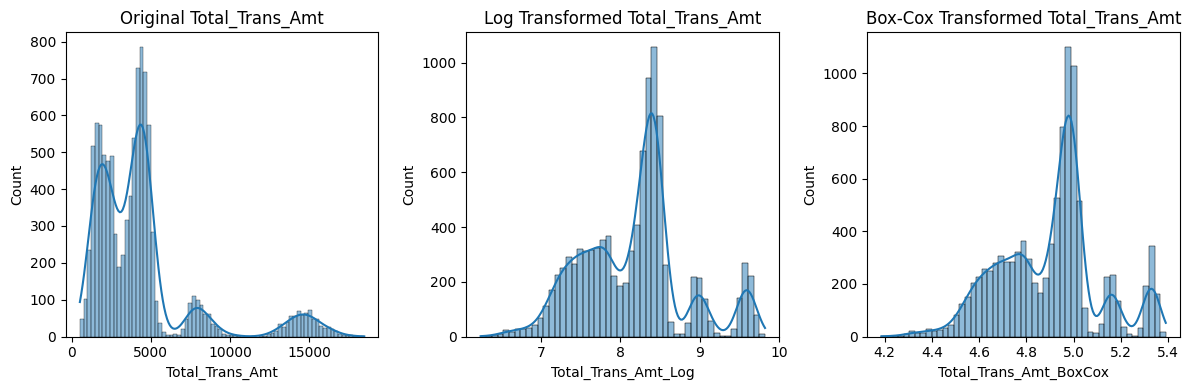

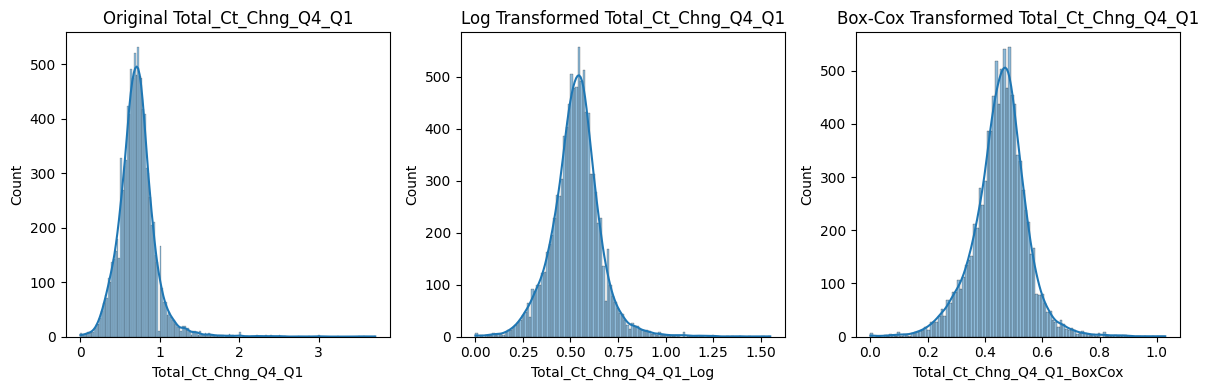

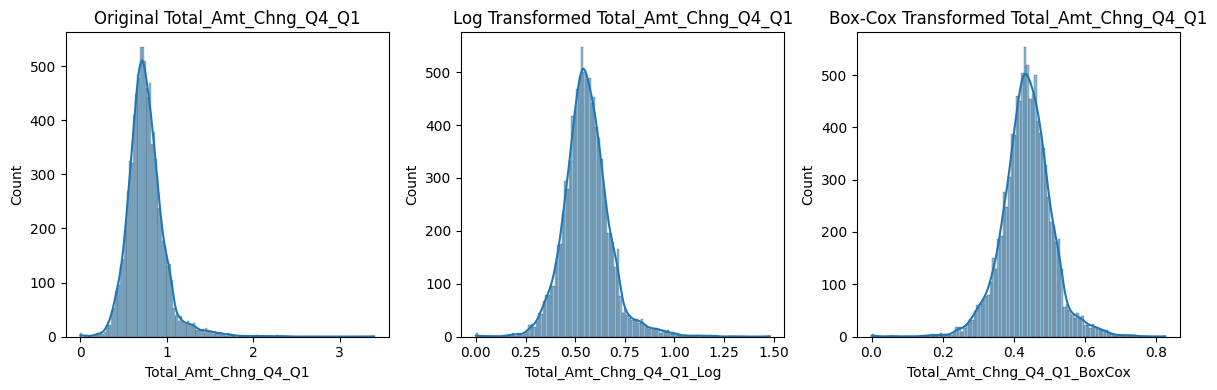

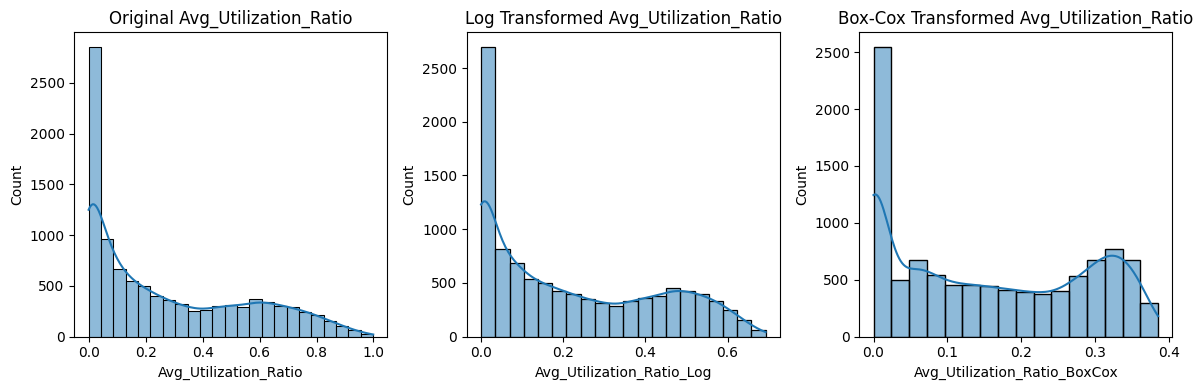

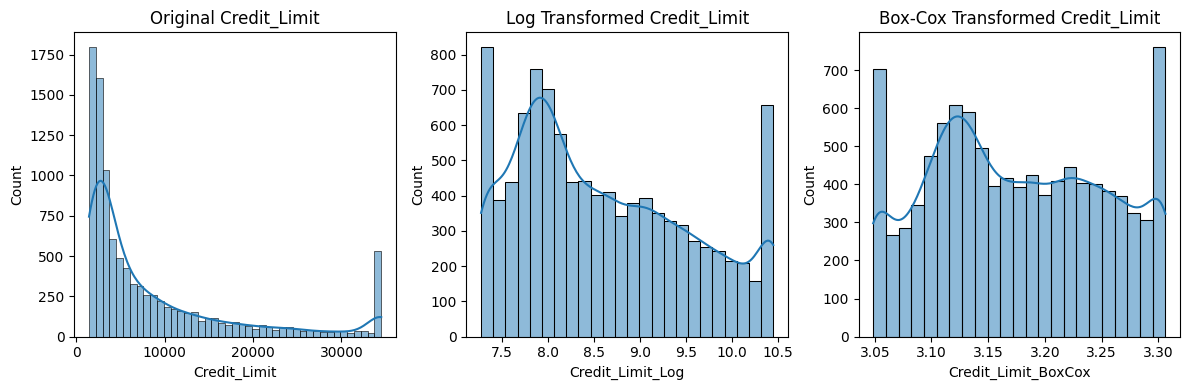

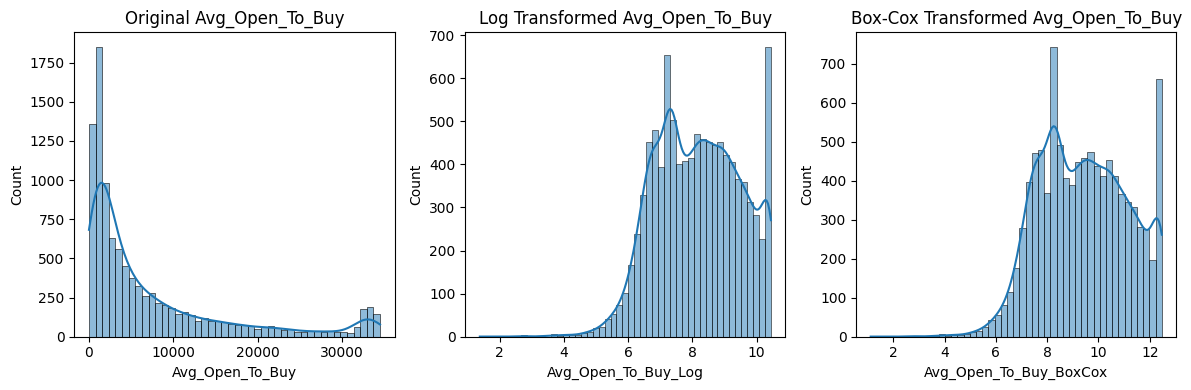

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame, and 'features_to_transform' is the list from the previous step.

for feature in features_to_transform:
    plt.figure(figsize=(12, 4))

    # Original Distribution
    plt.subplot(1, 3, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Original {feature}')

    # Log Transformed Distribution
    plt.subplot(1, 3, 2)
    sns.histplot(df[feature + '_Log'], kde=True)
    plt.title(f'Log Transformed {feature}')

    # Box-Cox Transformed Distribution
    plt.subplot(1, 3, 3)
    sns.histplot(df[feature + '_BoxCox'], kde=True)
    plt.title(f'Box-Cox Transformed {feature}')

    plt.tight_layout()
    plt.show()

In [29]:
print(df[[feature + '_Log', feature + '_BoxCox']].skew())

Avg_Open_To_Buy_Log      -0.095298
Avg_Open_To_Buy_BoxCox   -0.009088
dtype: float64


### Step 6 Takeaways:
Box-Cox transformation does appear to produce a more symmetrical distribution than the log transformation. The original distribution is bimodal and right-skewed. The log transformation reduces the skew but retains some bimodality. The Box-Cox transformation, however, results in a distribution that is closer to a normal distribution, although the bimodality isn't entirely eliminated.

### Step 7: Finalizing df for modeling and other efforts

In [30]:
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Total_Ct_Chng_Q4_Q1_Log,Total_Ct_Chng_Q4_Q1_BoxCox,Total_Amt_Chng_Q4_Q1_Log,Total_Amt_Chng_Q4_Q1_BoxCox,Avg_Utilization_Ratio_Log,Avg_Utilization_Ratio_BoxCox,Credit_Limit_Log,Credit_Limit_BoxCox,Avg_Open_To_Buy_Log,Avg_Open_To_Buy_BoxCox
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,0.965081,0.742157,0.848012,0.596514,0.059212,0.056012,9.448727,3.248734,9.385553,10.994245
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,1.550537,1.029180,0.932558,0.634983,0.099845,0.090971,9.018817,3.218467,8.908289,10.349511
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,1.203873,0.870893,1.279266,0.765820,0.000000,0.000000,8.137103,3.143352,8.137103,9.328766
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,1.203873,0.870893,0.877550,0.610283,0.565314,0.346986,8.105911,3.140330,6.680855,7.469609
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,1.252763,0.895156,1.155308,0.723576,0.000000,0.000000,8.458928,3.173000,8.458928,9.751611


In [31]:
# 1. Create a list of the _Log columns to drop
log_columns_to_drop = [feature + '_Log' for feature in features_to_transform]

# 2. Drop the _Log columns
df = df.drop(columns=log_columns_to_drop, errors='ignore')

# The DataFrame 'df' now contains only the original features and the Box-Cox transformed versions.

# Verification (optional):
print(df.columns) # See the remaining columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Total_Trans_Amt_BoxCox', 'Total_Ct_Chng_Q4_Q1_BoxCox',
       'Total_Amt_Chng_Q4_Q1_BoxCox', 'Avg_Utilization_Ratio_BoxCox',
       'Credit_Limit_BoxCox', 'Avg_Open_To_Buy_BoxCox'],
      dtype='object')


In [32]:

# 1. Identify Box-Cox Transformed Features:
boxcox_features = [col for col in df.columns if col.endswith('_BoxCox')]

# 2. Identify Original Features to Remove:
original_features_to_remove = [col.replace('_BoxCox', '') for col in boxcox_features]

# 3. Create Filtered DataFrame:
final_df = df.drop(columns=original_features_to_remove, errors='ignore')

# Verification:
print(final_df.columns)

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Trans_Ct',
       'Total_Trans_Amt_BoxCox', 'Total_Ct_Chng_Q4_Q1_BoxCox',
       'Total_Amt_Chng_Q4_Q1_BoxCox', 'Avg_Utilization_Ratio_BoxCox',
       'Credit_Limit_BoxCox', 'Avg_Open_To_Buy_BoxCox'],
      dtype='object')
